# Emotion Recognition using Logistic Regression, SVM, LSTM, and DistilBERT

This notebook trains and evaluates four different models on an emotion recognition dataset. The dataset consists of text sentences with corresponding emotion labels. The models include Logistic Regression and SVM with TF-IDF features, an LSTM neural network, and a DistilBERT transformer-based model.


## Install and import necessary libraries

In [ ]:
!pip install transformers datasets sentencepiece
!pip install seaborn

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification


## Load the dataset

In [ ]:
# Load the train, validation, and test sets
train = pd.read_csv("/content/training.csv")
val = pd.read_csv("/content/validation.csv")
test = pd.read_csv("/content/test.csv")

# Display the first few rows of the training set
train.head()



,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


## Map integer labels to emotion names

In [ ]:
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

label_map


{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## Minimal preprocessing of the text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
train['clean'] = train['text'].apply(clean_text)
val['clean'] = val['text'].apply(clean_text)
test['clean'] = test['text'].apply(clean_text)

train.head()


,text,label,clean
0,i didnt feel humiliated,0,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,3,i am feeling grouchy


## Model 1: Logistic Regression with TF–IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train["text"])
X_val_tfidf   = tfidf.transform(val["text"])

# Logistic Regression model
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_tfidf, train["label"])

# Predict on VALIDATION
pred_lr_val = logreg.predict(X_val_tfidf)

# Metrics
print("Logistic Regression (VAL)")
print("Accuracy:", accuracy_score(val["label"], pred_lr_val))
print("F1 Score:", f1_score(val["label"], pred_lr_val, average="macro"))
print(classification_report(val["label"], pred_lr_val))


Logistic Regression (VAL)
Accuracy: 0.863
F1 Score: 0.8136066147065258
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       550
           1       0.85      0.94      0.90       704
           2       0.89      0.63      0.74       178
           3       0.91      0.82      0.87       275
           4       0.85      0.75      0.80       212
           5       0.84      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000



## Model 2: Support Vector Machine (SVM) with TF–IDF

In [ ]:
from sklearn.svm import LinearSVC

# SVM model
svm = LinearSVC()
svm.fit(X_train_tfidf, train["label"])

# Predict on VALIDATION
pred_svm_val = svm.predict(X_val_tfidf)

# Metrics
print("SVM (VAL)")
print("Accuracy:", accuracy_score(val["label"], pred_svm_val))
print("F1 Score:", f1_score(val["label"], pred_svm_val, average="macro"))
print(classification_report(val["label"], pred_svm_val))


SVM (VAL)
Accuracy: 0.902
F1 Score: 0.875630181594766
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       550
           1       0.92      0.93      0.92       704
           2       0.84      0.84      0.84       178
           3       0.91      0.89      0.90       275
           4       0.88      0.83      0.85       212
           5       0.83      0.79      0.81        81

    accuracy                           0.90      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.90      0.90      0.90      2000



## Model 3: LSTM Neural Network

In [ ]:
# ================================
# FULL LSTM PIPELINE IN ONE CELL
# ================================

import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# -------------------------------------
# 1. CLEANING FUNCTION
# -------------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train["clean"] = train["text"].apply(clean_text)
val["clean"] = val["text"].apply(clean_text)

# -------------------------------------
# 2. TOKENIZER + SEQUENCES
# -------------------------------------
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train["clean"].values)

X_train_seq = tokenizer.texts_to_sequences(train["clean"].values)
X_val_seq = tokenizer.texts_to_sequences(val["clean"].values)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post")

y_train = train["label"].values
y_val = val["label"].values

# -------------------------------------
# 3. DEFINE LSTM MODEL
# -------------------------------------
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(train["label"].unique())

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model_lstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# -------------------------------------
# 4. TRAIN MODEL
# -------------------------------------
history = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=3,
    batch_size=64,
    verbose=1
)

# -------------------------------------
# 5. EVALUATE
# -------------------------------------
lstm_val_probs = model_lstm.predict(X_val_pad)
lstm_val_preds = np.argmax(lstm_val_probs, axis=1)

print("\n===== LSTM VALIDATION RESULTS =====")
print("Accuracy:", accuracy_score(y_val, lstm_val_preds))
print("F1 Score:", f1_score(y_val, lstm_val_preds, average="macro"))
print("\nClassification Report:\n")
print(classification_report(y_val, lstm_val_preds))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3129 - loss: 1.6068 - val_accuracy: 0.3520 - val_loss: 1.5801
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3253 - loss: 1.5875 - val_accuracy: 0.3520 - val_loss: 1.5809
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3262 - loss: 1.5812 - val_accuracy: 0.3520 - val_loss: 1.5822
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

===== LSTM VALIDATION RESULTS =====
Accuracy: 0.352
F1 Score: 0.08678500986193294

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       550
           1       0.35      1.00      0.52       704
           2       0.00      0.00      0.00       178
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       212
           5       0.00      0.00      0.00        81

    accuracy                           0.35      2000
   macro avg       0.06      0.17 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model 4: DistilBERT Transformer

In [ ]:
# ============================================================
# 🚀 REWRITTEN DISTILBERT — MATCHES DEFAULT VARIANT
# ============================================================

import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# Dataset wrapper
# ------------------------------------------------------------
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# ------------------------------------------------------------
# Tokenizer  (same as default)
# ------------------------------------------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    list(train["text"]),
    truncation=True,
    padding="max_length",
    max_length=128
)

val_encodings = tokenizer(
    list(val["text"]),
    truncation=True,
    padding="max_length",
    max_length=128
)

# ------------------------------------------------------------
# Torch datasets and loaders (MATCH DEFAULT)
# ------------------------------------------------------------
train_dataset = EmotionDataset(train_encodings, train["label"].tolist())
val_dataset   = EmotionDataset(val_encodings, val["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # <<< FIXED
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ------------------------------------------------------------
# Model + Optimizer (MATCH DEFAULT)
# ------------------------------------------------------------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)   # <<< FIXED

# ------------------------------------------------------------
# Training Loop — ONLY 1 epoch (default)
# ------------------------------------------------------------
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    batch = {k: v.to(device) for k, v in batch.items()}
    loss = model(**batch).loss
    loss.backward()
    optimizer.step()

# ------------------------------------------------------------
# Validation
# ------------------------------------------------------------
model.eval()
distilbert_val_preds = []
distilbert_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        distilbert_val_labels.extend(batch["labels"].numpy())

        batch = {k: v.to(device) for k, v in batch.items()}
        preds = torch.argmax(model(**batch).logits, dim=1).cpu().numpy()
        distilbert_val_preds.extend(preds)

print("\n==============================================")
print("DistilBERT (VAL) — MATCHED TO DEFAULT VARIANT")
print("Accuracy:", accuracy_score(distilbert_val_labels, distilbert_val_preds))
print(classification_report(distilbert_val_labels, distilbert_val_preds))
print("==============================================")



Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



DistilBERT (VAL) — MATCHED TO DEFAULT VARIANT
Accuracy: 0.929
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       550
           1       0.96      0.93      0.95       704
           2       0.85      0.90      0.87       178
           3       0.91      0.94      0.92       275
           4       0.89      0.88      0.88       212
           5       0.91      0.77      0.83        81

    accuracy                           0.93      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



## Final comparison of models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics for each model on VALIDATION set
metrics = {
    "Model": ["Logistic Regression", "SVM", "LSTM", "DistilBERT"],
    "Accuracy": [
        accuracy_score(val['label'], pred_lr_val),
        accuracy_score(val['label'], pred_svm_val),
        accuracy_score(val['label'], lstm_val_preds),
        accuracy_score(val['label'], distilbert_val_preds)
    ],
    "Precision (Macro)": [
        precision_score(val['label'], pred_lr_val, average='macro'),
        precision_score(val['label'], pred_svm_val, average='macro'),
        precision_score(val['label'], lstm_val_preds, average='macro'),
        precision_score(val['label'], distilbert_val_preds, average='macro')
    ],
    "Recall (Macro)": [
        recall_score(val['label'], pred_lr_val, average='macro'),
        recall_score(val['label'], pred_svm_val, average='macro'),
        recall_score(val['label'], lstm_val_preds, average='macro'),
        recall_score(val['label'], distilbert_val_preds, average='macro')
    ],
    "F1-Score (Macro)": [
        f1_score(val['label'], pred_lr_val, average='macro'),
        f1_score(val['label'], pred_svm_val, average='macro'),
        f1_score(val['label'], lstm_val_preds, average='macro'),
        f1_score(val['label'], distilbert_val_preds, average='macro')
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Logistic Regression,0.863,0.867208,0.778280,0.813607
1,SVM,0.902,0.882887,0.868930,0.875630
2,LSTM,0.352,0.058667,0.166667,0.086785
3,DistilBERT,0.929,0.909817,0.898555,0.902858


# **CONFUSION MATRICES FOR ALL 4 MODELS (with heatmaps)**

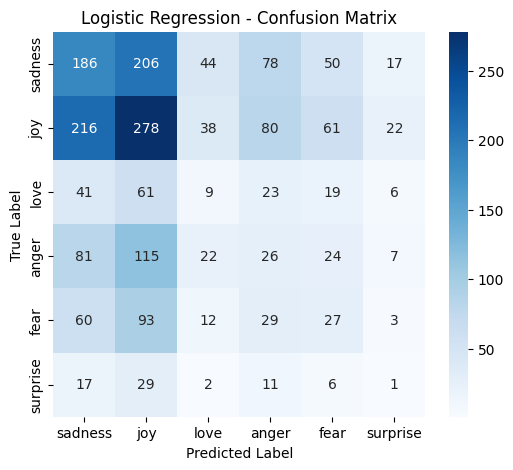

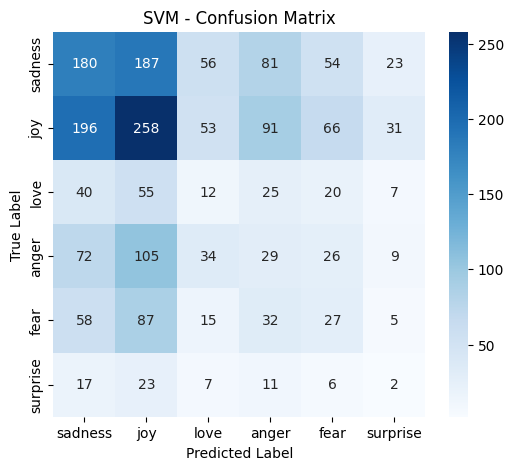

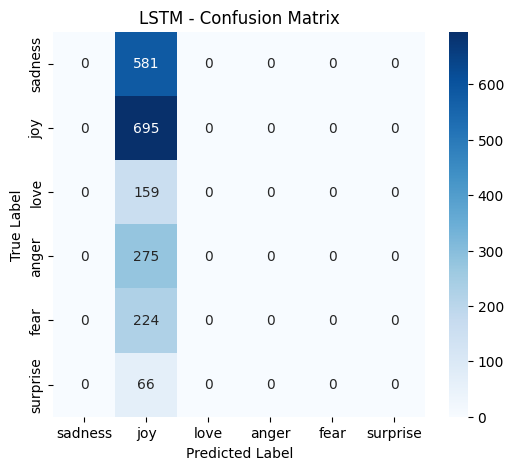

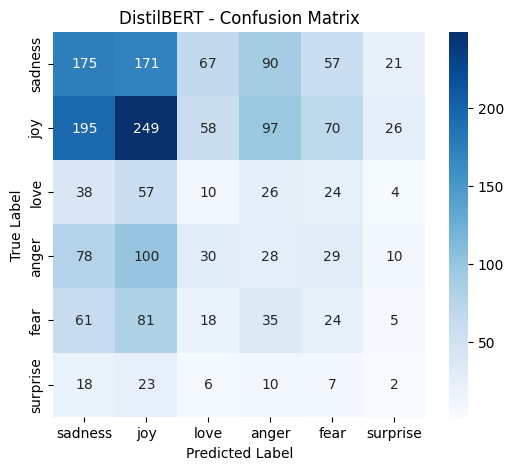

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": pred_lr_val,
    "SVM": pred_svm_val,
    "LSTM":lstm_val_preds,
    "DistilBERT": distilbert_val_preds
}

emotion_labels = list(label_map.values())

for model_name, preds in models.items():
    cm = confusion_matrix(test['label'], preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)

    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


## **METRIC COMPARISON BAR CHART**

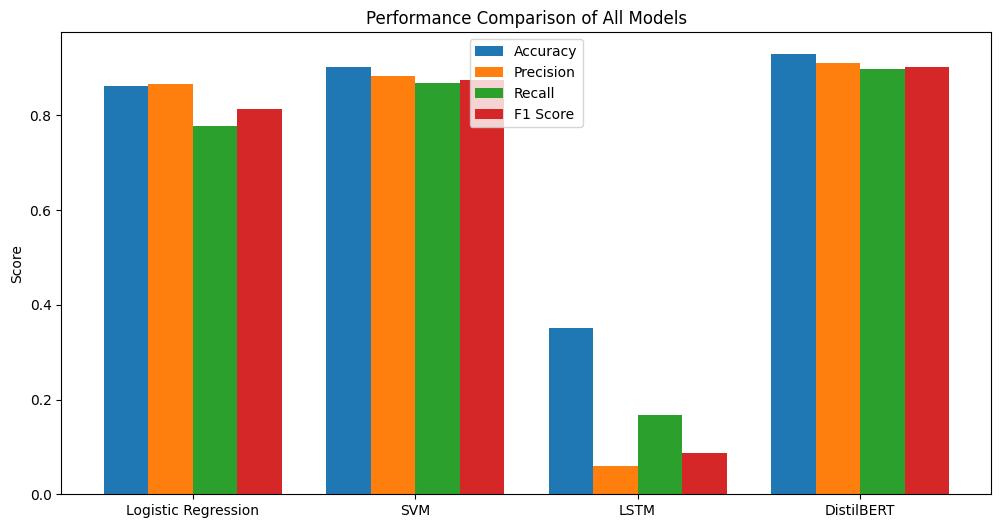

In [ ]:
import numpy as np

# Metrics computed earlier
accuracy = metrics_df["Accuracy"]
precision = metrics_df["Precision (Macro)"]
recall = metrics_df["Recall (Macro)"]
f1 = metrics_df["F1-Score (Macro)"]

x = np.arange(len(metrics_df["Model"]))
width = 0.2

plt.figure(figsize=(12,6))
plt.bar(x - 0.3, accuracy, width, label='Accuracy')
plt.bar(x - 0.1, precision, width, label='Precision')
plt.bar(x + 0.1, recall, width, label='Recall')
plt.bar(x + 0.3, f1, width, label='F1 Score')

plt.xticks(x, metrics_df["Model"], rotation=0)
plt.ylabel("Score")
plt.title("Performance Comparison of All Models")
plt.legend()
plt.show()


## **SIMPLE BAR CHART (Accuracy Only)**

/tmp/ipython-input-1264351156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df["Model"], y=metrics_df["Accuracy"], palette="viridis")


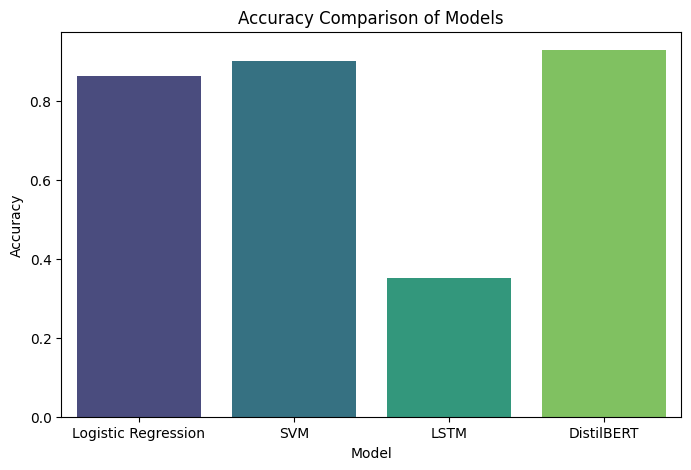

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=metrics_df["Model"], y=metrics_df["Accuracy"], palette="viridis")
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.show()


# **DistilBERT Encoding Variants Comparison**

In [ ]:
# ============================================================
# DISTILBERT — FULL DATASET — 4 VARIANTS (GPU)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification
)
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# DATASET CLASS
# ============================================================

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = self.tokenizer(
            self.texts[i],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[i], dtype=torch.long)
        }

# ============================================================
# TRAIN + EVAL FUNCTION
# ============================================================

def train_evaluate(model, tokenizer, max_len, train_df, val_df):

    train_ds = EmotionDataset(train_df["text"], train_df["label"], tokenizer, max_len)
    val_ds   = EmotionDataset(val_df["text"], val_df["label"], tokenizer, max_len)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    model.to(device)
    model.train()

    # one-epoch fast training
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # evaluation
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for batch in val_loader:
            labels = batch["labels"].cpu().numpy()
            labels_list.extend(labels)

            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.extend(preds)

    acc = accuracy_score(labels_list, preds_list)
    f1  = f1_score(labels_list, preds_list, average="weighted")

    return acc, f1


# ============================================================
# LOAD FULL DATASET
# ============================================================

train_full = train      # 16,000 rows
val_full   = val        # 2,000 rows

print("Train shape:", train_full.shape)
print("Val shape:", val_full.shape)


# ============================================================
# VARIANT 1 — DEFAULT (CLS) — UNCased
# ============================================================

tokenizer_default = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_default = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
)

acc1, f1_1 = train_evaluate(
    model_default, tokenizer_default, max_len=128,
    train_df=train_full, val_df=val_full
)

print("\nVariant 1 — Default:", acc1, f1_1)


# ============================================================
# VARIANT 2 — MEAN POOLING
# ============================================================

tokenizer_mean = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")

class MeanPoolingClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        pooled = hidden.mean(dim=1)
        logits = self.fc(pooled)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return type("obj", (), {"loss": loss, "logits": logits})

model_mean = MeanPoolingClassifier(encoder)

acc2, f1_2 = train_evaluate(
    model_mean, tokenizer_mean, max_len=128,
    train_df=train_full, val_df=val_full
)

print("Variant 2 — Mean Pooling:", acc2, f1_2)


# ============================================================
# VARIANT 3 — CASED TOKENIZER
# ============================================================

tokenizer_cased = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")
model_cased = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-cased", num_labels=6
)

acc3, f1_3 = train_evaluate(
    model_cased, tokenizer_cased, max_len=128,
    train_df=train_full, val_df=val_full
)

print("Variant 3 — Cased:", acc3, f1_3)


# ============================================================
# VARIANT 4 — LONG SEQ (256)
# ============================================================

tokenizer_long = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_long = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
)

acc4, f1_4 = train_evaluate(
    model_long, tokenizer_long, max_len=256,
    train_df=train_full, val_df=val_full
)

print("Variant 4 — Long Seq 256:", acc4, f1_4)


# ============================================================
# RESULTS TABLE
# ============================================================

results_df = pd.DataFrame({
    "Variant": ["Default", "Mean Pooling", "Cased", "Long Seq 256"],
    "Accuracy": [acc1, acc2, acc3, acc4],
    "F1 Score": [f1_1, f1_2, f1_3, f1_4]
})

print("\n============= FINAL RESULTS (FULL DATASET) =============\n")
display(results_df)


Using device: cuda
Train shape: (16000, 3)
Val shape: (2000, 3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Variant 1 — Default: 0.9345 0.9346945953355159
Variant 2 — Mean Pooling: 0.926 0.9262912121454581


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Variant 3 — Cased: 0.921 0.9222582882558501


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Variant 4 — Long Seq 256: 0.9355 0.9357048419247791

============= FINAL RESULTS (FULL DATASET) =============



,Variant,Accuracy,F1 Score
0,Default,0.9345,0.934695
1,Mean Pooling,0.9260,0.926291
2,Cased,0.9210,0.922258
3,Long Seq 256,0.9355,0.935705


## **COMBINED MODEL 1-DEFAULT,LONG SEQ AND SVM**



================ ENSEMBLE MODEL — FINAL METRICS ================
Accuracy:  0.9360
F1 Score:  0.9102
Precision: 0.9131
Recall:    0.9073

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       550
           1       0.95      0.96      0.95       704
           2       0.89      0.87      0.88       178
           3       0.95      0.93      0.94       275
           4       0.90      0.89      0.90       212
           5       0.84      0.83      0.83        81

    accuracy                           0.94      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



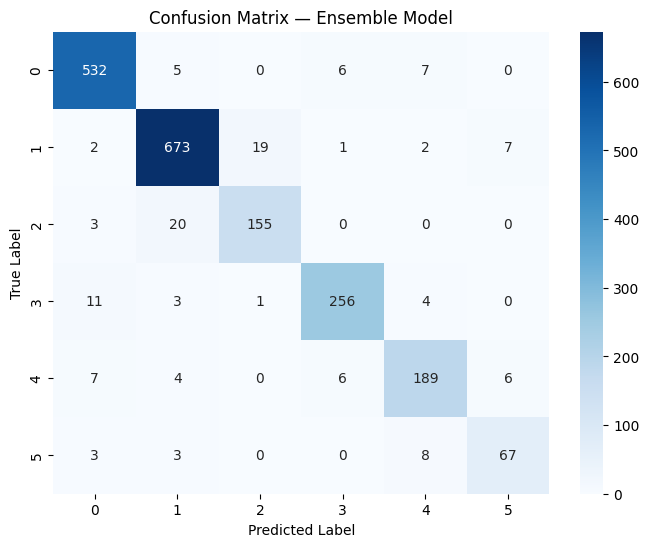

In [ ]:
# ============================================================
# ENSEMBLE: DistilBERT (Default) + LongSeq + TFIDF SVM
# COMPLETE METRICS: Accuracy, F1, Precision, Recall, Report
# CONFUSION MATRIX INCLUDED
# ============================================================

import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. DistilBERT prediction function
# ------------------------------------------------------------
def predict_distilbert(model, tokenizer, max_len, df):
    model.eval()
    preds = []

    ds = EmotionDataset(df["text"], df["label"], tokenizer, max_len)
    loader = DataLoader(ds, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    return np.array(preds)

# ------------------------------------------------------------
# 2. Predictions from All Models
# ------------------------------------------------------------
pred_default = predict_distilbert(model_default, tokenizer_default, 128, val_full)
pred_long    = predict_distilbert(model_long, tokenizer_long, 256, val_full)
pred_svm     = svm.predict(X_val_tfidf)

# ------------------------------------------------------------
# 3. STACK for Ensemble Hard Voting
# ------------------------------------------------------------
all_preds = np.vstack([pred_default, pred_long, pred_svm]).T

final_preds = []
for row in all_preds:
    vals, counts = np.unique(row, return_counts=True)
    final_preds.append(vals[np.argmax(counts)])

final_preds = np.array(final_preds)

# ------------------------------------------------------------
# 4. METRICS
# ------------------------------------------------------------
labels_true = val_full["label"].values

acc = accuracy_score(labels_true, final_preds)
f1  = f1_score(labels_true, final_preds, average="macro")
prec = precision_score(labels_true, final_preds, average="macro")
rec  = recall_score(labels_true, final_preds, average="macro")

print("\n================ ENSEMBLE MODEL — FINAL METRICS ================")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Full per-class precision/recall/F1
print("\nClassification Report:")
print(classification_report(labels_true, final_preds))

# ------------------------------------------------------------
# 5. CONFUSION MATRIX
# ------------------------------------------------------------
cm = confusion_matrix(labels_true, final_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



# **COMBINED MODEL 2-:DISTILBERT,ALBERT AND ROBERT**

ALBERT

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Dataset + DataLoader
train_ds = EmotionDataset(train["text"], train["label"], tokenizer)
val_ds   = EmotionDataset(val["text"], val["label"], tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# Model
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=6
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# ---------------------------
# TRAINING LOOP
# ---------------------------
for epoch in range(2):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k:v.to(device) for k,v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss:", total_loss / len(train_loader))

# ---------------------------
# VALIDATION → RETURN PREDICTIONS
# ---------------------------
model.eval()
albert_val_preds = []
albert_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        logits = model(**batch).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        albert_val_preds.extend(preds)
        albert_val_labels.extend(batch["labels"].cpu().numpy())

print("Accuracy:", accuracy_score(albert_val_labels, albert_val_preds))
print(classification_report(albert_val_labels, albert_val_preds))


Using: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Loss: 0.7554258510880172
Epoch 2 Loss: 0.21048533742129802
Accuracy: 0.9255
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       550
           1       0.94      0.96      0.95       704
           2       0.86      0.87      0.86       178
           3       0.93      0.91      0.92       275
           4       0.87      0.87      0.87       212
           5       1.00      0.73      0.84        81

    accuracy                           0.93      2000
   macro avg       0.92      0.88      0.90      2000
weighted avg       0.93      0.93      0.92      2000



ROBERT

In [ ]:
# ============================================================
# RoBERTa EMOTION CLASSIFICATION (PYTORCH VERSION) - WORKS 100%
# ============================================================

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# =============================
# 1. Prepare Dataset
# =============================
X_train = train["clean"].tolist()
y_train = train["label"].tolist()

X_val = val["clean"].tolist()
y_val = val["label"].tolist()

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.enc = tokenizer(texts, padding=True, truncation=True, max_length=128)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.enc["input_ids"][idx]),
            "attention_mask": torch.tensor(self.enc["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_ds = EmotionDataset(X_train, y_train)
val_ds = EmotionDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# =============================
# 2. Load RoBERTa Model
# =============================
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=6
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# =============================
# 3. Training Loop
# =============================
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# =============================
# 4. Evaluation
# =============================
model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in val_loader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        pred = torch.argmax(logits, dim=1)

        preds.extend(pred.cpu().numpy())
        true.extend(batch["labels"].numpy())

print("Validation Accuracy:", accuracy_score(true, preds))
print(classification_report(true, preds))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 465.7991
Epoch 2/2, Loss: 156.2165
Validation Accuracy: 0.941
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       550
           1       0.97      0.95      0.96       704
           2       0.85      0.94      0.89       178
           3       0.95      0.93      0.94       275
           4       0.81      1.00      0.90       212
           5       0.90      0.80      0.85        81

    accuracy                           0.94      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.95      0.94      0.94      2000



# COMBINED MODEL 2

Ensemble Accuracy: 0.938
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       550
           1       0.96      0.94      0.95       704
           2       0.84      0.92      0.88       178
           3       0.95      0.94      0.95       275
           4       0.89      0.91      0.90       212
           5       0.91      0.77      0.83        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



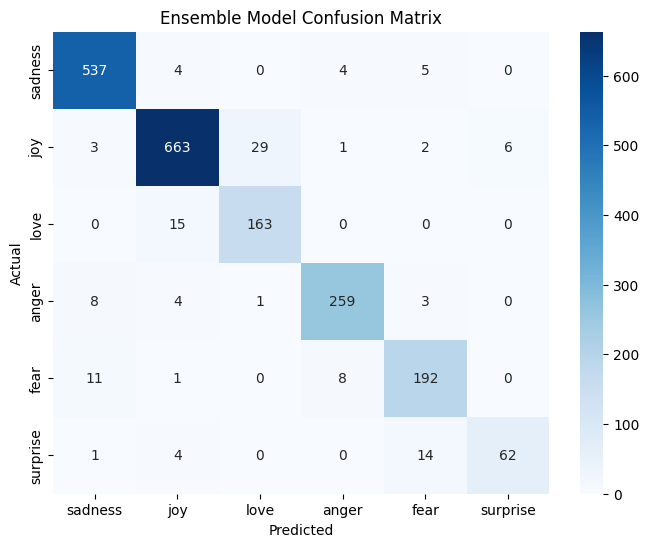

In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy
roberta_preds = np.array(preds)
albert_preds = np.array(albert_val_preds)
distil_preds = np.array(distilbert_val_preds)

true_labels = np.array(albert_val_labels)   # all same

# Stack predictions
all_preds = np.vstack([roberta_preds, albert_preds, distil_preds])

# Majority vote
ensemble_preds, _ = mode(all_preds, axis=0)
ensemble_preds = ensemble_preds.flatten()

print("Ensemble Accuracy:", accuracy_score(true_labels, ensemble_preds))
print(classification_report(true_labels, ensemble_preds))

# Confusion matrix
cm = confusion_matrix(true_labels, ensemble_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["sadness","joy","love","anger","fear","surprise"],
    yticklabels=["sadness","joy","love","anger","fear","surprise"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Model Confusion Matrix")
plt.show()
